In [1]:
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,data
0,754774dd-77e1-4cf5-b9b5-3afad9f41410,999edb9e-8a45-4115-84d5-fca75dcfa639.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-E2-A1IG,TCGA-E2-A1IG-01A,Primary Tumor,FPKM
1,8bf102b9-baf7-4749-bcd0-eca25f600722,23393a6a-bfbc-4dec-9ab5-e78a487a095f.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-EW-A1J5,TCGA-EW-A1J5-01A,Primary Tumor,FPKM
2,5bf7609e-68cb-4ddb-8f05-ee1d4f92cf9b,4a9bb3fd-4e75-4585-82f7-7254889b9838.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-AR-A1AU,TCGA-AR-A1AU-01A,Primary Tumor,FPKM
3,10a40ceb-080c-4758-97f9-1a262e2639ed,9858d286-1b96-4414-bd09-d73dc6f1c79e.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-DB-A64R,TCGA-DB-A64R-01A,Primary Tumor,FPKM
4,2600ef39-0bdf-4e10-9fdf-e3dbed7b5383,f7182de7-067e-467b-af88-790ad3e63eec.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-P5-A77X,TCGA-P5-A77X-01A,Primary Tumor,FPKM


Samples with RNAseq adjacent normal tissue

In [3]:
samples[samples['Sample Type']=='Solid Tissue Normal']['data'].value_counts()

FPKM    636
Name: data, dtype: int64

In [4]:
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
PAAD     171
ESCA     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [5]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [6]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & (samples['data']=='FPKM')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & (samples['data']=='FPKM')]['Case ID'].nunique()

622

636

In [7]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM')]
cases = case_norm[case_norm['Case ID'].isin(case_tumor['Case ID'])]['Case ID']
cases.shape

(622,)

In [8]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])

In [9]:
case_tumor.shape
case_norm.shape
cases.shape

(646, 10)

(622, 10)

(1268, 10)

## Dataset Prep

In [10]:
from sklearn.model_selection import train_test_split

target = 'Sample Type'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Solid Tissue Normal    477
Primary Tumor          474
Name: Sample Type, dtype: int64

Primary Tumor          172
Solid Tissue Normal    145
Name: Sample Type, dtype: int64

In [11]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = train[target].cat.categories.values


Cuda is available: True


In [12]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network

In [13]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 4
# print training metrics every log_interval * batch_size
log_interval = 50

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (0): Linear(in_features=60483, out_features=2000, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=2000, out_features=500, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=500, out_features=250, bias=True)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=250, out_features=100, bias=True)
      (7): PReLU(num_parameters=1)
      (8): Linear(in_features=100, out_features=50, bias=True)
      (9): PReLU(num_parameters=1)
      (10): Linear(in_features=50, out_features=10, bias=True)
      (11): PReLU(num_parameters=1)
      (12): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [14]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/951 (0%)]	Loss: 0.225314
Train: [400/951 (42%)]	Loss: 1.661050
Train: [800/951 (84%)]	Loss: 0.322891
Epoch: 1/4. Train set: Average loss: 1.1446
Epoch: 1/4. Validation set: Average loss: 5.2528
Train: [0/951 (0%)]	Loss: 2.921545
Train: [400/951 (42%)]	Loss: 0.350895
Train: [800/951 (84%)]	Loss: 0.171230
Epoch: 2/4. Train set: Average loss: 0.2597
Epoch: 2/4. Validation set: Average loss: 0.1583
Train: [0/951 (0%)]	Loss: 0.019549
Train: [400/951 (42%)]	Loss: 0.110191
Train: [800/951 (84%)]	Loss: 0.063071
Epoch: 3/4. Train set: Average loss: 0.0818
Epoch: 3/4. Validation set: Average loss: 0.0819
Train: [0/951 (0%)]	Loss: 0.056842
Train: [400/951 (42%)]	Loss: 0.043173
Train: [800/951 (84%)]	Loss: 0.052621
Epoch: 4/4. Train set: Average loss: 0.0532
Epoch: 4/4. Validation set: Average loss: 0.0571


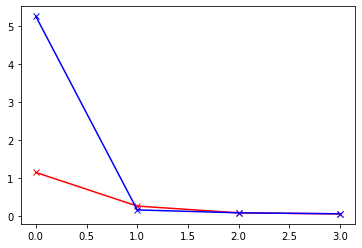

In [15]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

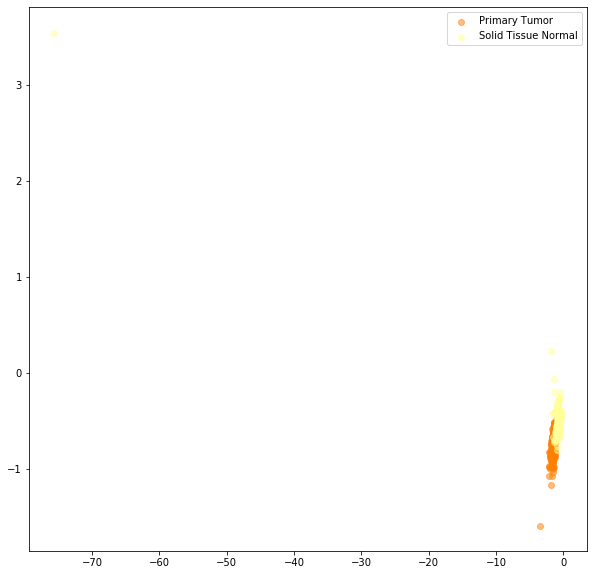

In [16]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, classes)

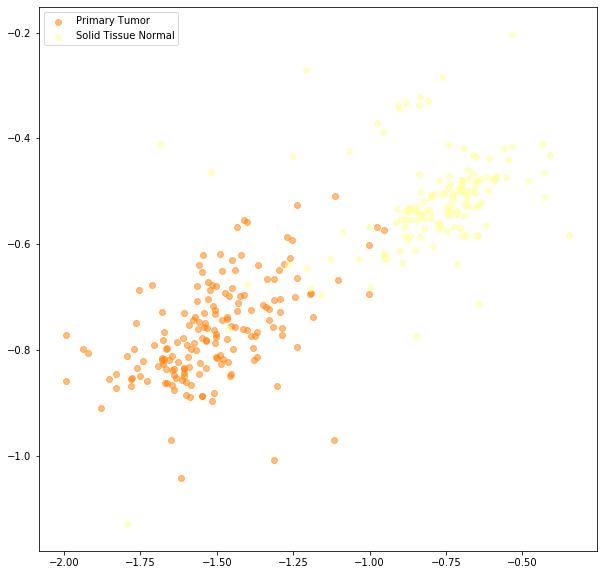

In [17]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, classes)

## Saliency

In [18]:
saliency_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=1, shuffle=False, **kwargs)

In [19]:
def saliency_eval(val_loader, model, loss_fn, cuda):
    model.eval()
    val_loss = 0
    saliency_pairs = (torch.zeros(len(val_loader), 60483), torch.zeros(len(val_loader), 60483), torch.zeros(len(val_loader)))
    for batch_idx, (data, target) in enumerate(val_loader):
        model.zero_grad()
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()
        # need to instantiate input with require_grad!
        data = (Variable(data[0], requires_grad=True), Variable(data[1], requires_grad=True))
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)
        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        loss.backward()
        saliency_pairs[0][batch_idx] = data[0].grad
        saliency_pairs[1][batch_idx] = data[1].grad
        saliency_pairs[2][batch_idx] = loss.item()
        val_loss += loss.item()

    return val_loss, saliency_pairs


In [22]:
val_loss, saliency_pairs = saliency_eval(saliency_loader, model, loss_fn, cuda)

In [23]:
min_loss = torch.where(saliency_pairs[2]==saliency_pairs[2].min())[0]

In [31]:
test_pairs = np.array(siamese_test_dataset.test_pairs)

In [30]:
ex1 = pd.DataFrame(saliency_pairs[0].numpy(), columns=test_dataset.data.columns, index=test_pairs[:,0])
ex2 = pd.DataFrame(saliency_pairs[1].numpy(), columns=test_dataset.data.columns, index=test_pairs[:,1])
ex1.head()
ex2.head()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,ENSG00000231981.3,ENSG00000269475.2,ENSG00000201788.1,ENSG00000134108.11,ENSG00000263089.1,ENSG00000172137.17,ENSG00000167700.7,ENSG00000234943.2,ENSG00000240423.1,ENSG00000060642.9,ENSG00000271616.1,ENSG00000234881.1,ENSG00000236040.1,ENSG00000231105.1,ENSG00000243044.1,ENSG00000182141.8,ENSG00000269416.4,ENSG00000264981.1,ENSG00000275265.1,ENSG00000185105.4,ENSG00000233540.1,ENSG00000102174.8,ENSG00000271647.1,ENSG00000166391.13,ENSG00000270469.1,ENSG00000070087.12,ENSG00000262950.1,ENSG00000255420.1,ENSG00000280038.1,ENSG00000266261.1,ENSG00000153561.11,ENSG00000269148.1,ENSG00000274458.1,ENSG00000273406.1,ENSG00000179262.8,ENSG00000214198.6,ENSG00000278099.1,ENSG00000166368.2,ENSG00000206072.11,ENSG00000234900.1,ENSG00000258630.1,ENSG00000127511.8,ENSG00000220993.1,ENSG00000225269.2,ENSG00000214062.5,ENSG00000095587.8,ENSG00000274219.1,ENSG00000230100.1,ENSG00000064601.15,ENSG00000227766.1,ENSG00000008517.15,ENSG00000215246.5,ENSG00000266644.1,ENSG00000236893.1,ENSG00000254465.1,ENSG00000088179.7,ENSG00000070081.14,ENSG00000275479.1,ENSG00000166634.5,ENSG00000261789.1,ENSG00000254092.1,ENSG00000197421.8,ENSG00000161558.9,ENSG00000276644.3,ENSG00000260900.1,ENSG00000278732.1,ENSG00000196167.8,ENSG00000268465.1,ENSG00000264438.2,ENSG00000204113.6,ENSG00000207000.1,ENSG00000254131.1,ENSG00000118972.1,ENSG00000264104.1,ENSG00000179833.4,ENSG00000264576.1,ENSG00000064225.11,ENSG00000267108.1,ENSG00000221372.1,ENSGR0000264510.4,ENSG00000057294.12,ENSG00000227535.2,ENSG00000252628.2,ENSG00000166007.11,ENSG00000273055.1,ENSG00000242041.1,ENSG00000278923.1,ENSG00000167768.4,ENSG00000280159.1,ENSG00000235240.1,ENSG00000264172.1,ENSG00000199903.1,ENSG00000200058.1,ENSG00000275358.1,ENSG00000218358.2,ENSG00000266460.1,ENSG00000260371.1,ENSG00000264091.1,ENSG00000238921.2,ENSG00000274815.1,ENSG00000269349.1,ENSG00000200291.1,ENSG00000233614.6,ENSG00000022567.8,ENSG00000241670.3,ENSG00000278933.1,ENSG00000202175.1,ENSG00000120662.14,ENSG00000235523.1,ENSG00000249848.1,ENSG00000277826.1,ENSG00000230225.1,ENSG00000239877.2,ENSG00000201398.1,ENSG00000281474.1,ENSG00000272905.1,ENSG00000259952.1,ENSG00000260812.1,ENSG00000225630.1,ENSG00000230231.1,ENSG00000164283.11,ENSG00000231880.2,ENSG00000227489.1,ENSG00000254555.1,ENSG00000013392.7,ENSG00000258279.2,ENSG00000226688.5,ENSG00000250929.2,ENSG00000204581.2,ENSG00000225620.1,ENSG00000258477.1,ENSG00000225488.1,ENSG00000184178.14,ENSG00000237786.1,ENSG00000166913.11,ENSG00000275856.1,ENSG00000164112.11,ENSG00000259345.4,ENSG00000130204.11,ENSG00000280387.1,ENSG00000189099.10,ENSG00000232879.2,ENSG00000111863.11,ENSG00000164182.9,ENSG00000109618.10,ENSG00000271623.1,ENSG00000279345.1,ENSG00000214866.6,ENSG00000153015.14,ENSG00000202290.1,ENSG00000254578.1,ENSG00000240710.1,ENSG00000248778.1,ENSG00000250210.4,ENSG00000225215.1,ENSG00000257246.1,ENSG00000245017.2,ENSG00000281091.1,ENSG00000250885.1,ENSG00000273797.1,ENSG00000089116.3,ENSG00000036448.8,ENSG00000234055.1,ENSG00000267552.5,ENSG00000224695.1,ENSG00000106038.11,ENSG00000255189.1,ENSG00000164114.17,ENSG00000238698.1,ENSG00000199836.1,ENSG00000149089.11,ENSG00000251710.1,ENSG00000224570.1,ENSG00000179632.8,ENSG00000271677.1,ENSG00000114861.17,ENSG00000205030.1,ENSG00000138193.13,ENSG00000243073.3,ENSG00000152942.17,ENSG00000240809.1,ENSG00000280004.1,ENSG00000224560.3,ENSG00000227233.1,ENSG00000118363.10,ENSG00000258116.1,ENSG00000273311.1,ENSG00000136169.15,ENSG00000279700.1,ENSG00000121644.17,ENSG00000135903.17,ENSG00000138495.5,ENSG00000204528.3,ENSG00000169992.8,ENSG00000239344.1,ENSG00000253309.5,ENSG00000101323.4,ENSG00000272456.1,ENSG00000251538.4,ENSG00000263711.4,ENSG00000262662.1,ENSG00000127564.15,ENSG00000219395.2,ENSG00000255349.1,ENSG00000254843.1,ENSG00000277998.1,ENSG00000275248.1,ENSG00000226086.5,ENSG00000235023.1,ENSG00000176973.7,EN

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,ENSG00000231981.3,ENSG00000269475.2,ENSG00000201788.1,ENSG00000134108.11,ENSG00000263089.1,ENSG00000172137.17,ENSG00000167700.7,ENSG00000234943.2,ENSG00000240423.1,ENSG00000060642.9,ENSG00000271616.1,ENSG00000234881.1,ENSG00000236040.1,ENSG00000231105.1,ENSG00000243044.1,ENSG00000182141.8,ENSG00000269416.4,ENSG00000264981.1,ENSG00000275265.1,ENSG00000185105.4,ENSG00000233540.1,ENSG00000102174.8,ENSG00000271647.1,ENSG00000166391.13,ENSG00000270469.1,ENSG00000070087.12,ENSG00000262950.1,ENSG00000255420.1,ENSG00000280038.1,ENSG00000266261.1,ENSG00000153561.11,ENSG00000269148.1,ENSG00000274458.1,ENSG00000273406.1,ENSG00000179262.8,ENSG00000214198.6,ENSG00000278099.1,ENSG00000166368.2,ENSG00000206072.11,ENSG00000234900.1,ENSG00000258630.1,ENSG00000127511.8,ENSG00000220993.1,ENSG00000225269.2,ENSG00000214062.5,ENSG00000095587.8,ENSG00000274219.1,ENSG00000230100.1,ENSG00000064601.15,ENSG00000227766.1,ENSG00000008517.15,ENSG00000215246.5,ENSG00000266644.1,ENSG00000236893.1,ENSG00000254465.1,ENSG00000088179.7,ENSG00000070081.14,ENSG00000275479.1,ENSG00000166634.5,ENSG00000261789.1,ENSG00000254092.1,ENSG00000197421.8,ENSG00000161558.9,ENSG00000276644.3,ENSG00000260900.1,ENSG00000278732.1,ENSG00000196167.8,ENSG00000268465.1,ENSG00000264438.2,ENSG00000204113.6,ENSG00000207000.1,ENSG00000254131.1,ENSG00000118972.1,ENSG00000264104.1,ENSG00000179833.4,ENSG00000264576.1,ENSG00000064225.11,ENSG00000267108.1,ENSG00000221372.1,ENSGR0000264510.4,ENSG00000057294.12,ENSG00000227535.2,ENSG00000252628.2,ENSG00000166007.11,ENSG00000273055.1,ENSG00000242041.1,ENSG00000278923.1,ENSG00000167768.4,ENSG00000280159.1,ENSG00000235240.1,ENSG00000264172.1,ENSG00000199903.1,ENSG00000200058.1,ENSG00000275358.1,ENSG00000218358.2,ENSG00000266460.1,ENSG00000260371.1,ENSG00000264091.1,ENSG00000238921.2,ENSG00000274815.1,ENSG00000269349.1,ENSG00000200291.1,ENSG00000233614.6,ENSG00000022567.8,ENSG00000241670.3,ENSG00000278933.1,ENSG00000202175.1,ENSG00000120662.14,ENSG00000235523.1,ENSG00000249848.1,ENSG00000277826.1,ENSG00000230225.1,ENSG00000239877.2,ENSG00000201398.1,ENSG00000281474.1,ENSG00000272905.1,ENSG00000259952.1,ENSG00000260812.1,ENSG00000225630.1,ENSG00000230231.1,ENSG00000164283.11,ENSG00000231880.2,ENSG00000227489.1,ENSG00000254555.1,ENSG00000013392.7,ENSG00000258279.2,ENSG00000226688.5,ENSG00000250929.2,ENSG00000204581.2,ENSG00000225620.1,ENSG00000258477.1,ENSG00000225488.1,ENSG00000184178.14,ENSG00000237786.1,ENSG00000166913.11,ENSG00000275856.1,ENSG00000164112.11,ENSG00000259345.4,ENSG00000130204.11,ENSG00000280387.1,ENSG00000189099.10,ENSG00000232879.2,ENSG00000111863.11,ENSG00000164182.9,ENSG00000109618.10,ENSG00000271623.1,ENSG00000279345.1,ENSG00000214866.6,ENSG00000153015.14,ENSG00000202290.1,ENSG00000254578.1,ENSG00000240710.1,ENSG00000248778.1,ENSG00000250210.4,ENSG00000225215.1,ENSG00000257246.1,ENSG00000245017.2,ENSG00000281091.1,ENSG00000250885.1,ENSG00000273797.1,ENSG00000089116.3,ENSG00000036448.8,ENSG00000234055.1,ENSG00000267552.5,ENSG00000224695.1,ENSG00000106038.11,ENSG00000255189.1,ENSG00000164114.17,ENSG00000238698.1,ENSG00000199836.1,ENSG00000149089.11,ENSG00000251710.1,ENSG00000224570.1,ENSG00000179632.8,ENSG00000271677.1,ENSG00000114861.17,ENSG00000205030.1,ENSG00000138193.13,ENSG00000243073.3,ENSG00000152942.17,ENSG00000240809.1,ENSG00000280004.1,ENSG00000224560.3,ENSG00000227233.1,ENSG00000118363.10,ENSG00000258116.1,ENSG00000273311.1,ENSG00000136169.15,ENSG00000279700.1,ENSG00000121644.17,ENSG00000135903.17,ENSG00000138495.5,ENSG00000204528.3,ENSG00000169992.8,ENSG00000239344.1,ENSG00000253309.5,ENSG00000101323.4,ENSG00000272456.1,ENSG00000251538.4,ENSG00000263711.4,ENSG00000262662.1,ENSG00000127564.15,ENSG00000219395.2,ENSG00000255349.1,ENSG00000254843.1,ENSG00000277998.1,ENSG00000275248.1,ENSG00000226086.5,ENSG00000235023.1,ENSG00000176973.7,EN

In [33]:
pos_ind = np.where(test_pairs[:,2]==1)[0]
neg_ind = np.where(test_pairs[:,2]==0)[0]

In [41]:
ex1.iloc[neg_ind].mean().nlargest(10)

0
ENSG00000273892.1    0.000002
ENSG00000202144.1    0.000001
ENSG00000212528.1    0.000001
ENSG00000257721.1    0.000001
ENSG00000178591.6    0.000001
ENSG00000156009.8    0.000001
ENSG00000237326.1    0.000001
ENSG00000272558.1    0.000001
ENSG00000238644.1    0.000001
ENSG00000222776.1    0.000001
dtype: float32

In [42]:
ex1.iloc[neg_ind].mean().nsmallest(10)

0
ENSG00000279905.1    -0.000002
ENSG00000242072.1    -0.000002
ENSG00000072315.3    -0.000001
ENSG00000264576.1    -0.000001
ENSG00000198883.10   -0.000001
ENSG00000224223.1    -0.000001
ENSG00000271035.1    -0.000001
ENSG00000173404.4    -0.000001
ENSG00000266242.1    -0.000001
ENSG00000229332.2    -0.000001
dtype: float32

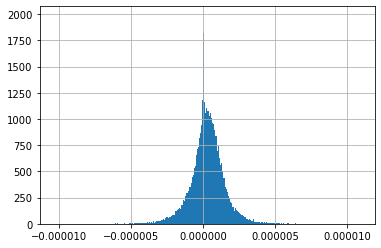

In [39]:
ex1.iloc[neg_ind[0]].T.hist(bins=500)